# Chapter 4 Training Models

## Linear Regression

A linear model makes a prediction by simply computing a weighted sum of the input features, plus a constant called the *bias term*: 

$$ \hat{y}=\theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n $$

In this equation: $\hat{y}$ is the predicted value, $n$ is the number of features, $x_i$ is the i-th feature value, and $\theta_j$ is the j-th model parameter (including the bias term $\theta_0$).

In vectorized form:
$$ \hat{y} = h_{\mathbf{\theta}}(\mathbf{x})=\mathbf{\theta}\cdot\mathbf{x} $$

If $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors, then the prediction is $\hat{y}=\mathbf{\theta}^{\text{T}}\mathbf{x}$, where $\mathbf{\theta}^{\text{T}}$ is the transpose of $\mathbf{\theta}$ and $\mathbf{\theta}^{\text{T}}\mathbf{x}$ is the matrix multiplication of the two vectors.

In order to train a linear regression model we first need a measure of how well the model fits the training data. The most common performance measure of a regression model is the Root Mean Square Error (RMSE). We need to find the value of $\mathbf{\theta}$ that minimizes the RMSE. Usually it's simpler to minimize the mean squared error (MSE) rather than the RMSE.

The MSE of a linear regression hypothesis $h_{\mathbf{\theta}}$ on a training set $\mathbf{X}$ is:

$$ MSE(\mathbf{X}, h_{\mathbf{\theta}})=\frac{1}{m}\sum^{m}_{i=1}\big(\mathbf{\theta}^{\text{T}}\mathbf{x}^{(i)}-y^{(i)}\big)^{2}$$

To find the value of $\mathbf{\theta}$ that minimizes the cost function, there is a analytical solution known as the *Normal Equation*.

$$ \hat{\mathbf{\theta}}=(\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{X}^{\text{T}}\mathbf{y} $$

There are also iterative methods which we will look at later. 

Let's use the normal equation to perform regression on some test data in Python:

(0.0, 2.0, 0.0, 15.0)

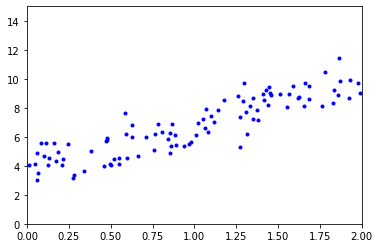

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])

In [2]:
X_b = np.c_[np.ones((100, 1)), X]  # adds x0 = 1 to each set of x features
print(X_b[:5])

[[1.         1.37515136]
 [1.         1.05334244]
 [1.         0.51949043]
 [1.         1.30896682]
 [1.         0.46183437]]


In [3]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.70030752],
       [3.1082869 ]])

Note that function that we just used to generate the data is $y=4+3x_{1}+\text{Gaussian noise}$. Now we can make predictions using $\hat{\mathbf{\theta}}$:

In [4]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[3.70030752],
       [9.91688132]])

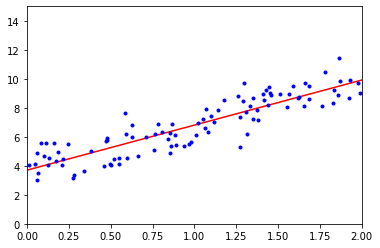

In [5]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

We can also perform linear regression with Scikit-Learn:

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.70030752]), array([[3.1082869]]))

In [7]:
lin_reg.predict(X_new)

array([[3.70030752],
       [9.91688132]])

The `LinearRegression` class is actually based on the `scipy.linalg.lstsq()` function. We can call that directly too:

In [8]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.70030752],
       [3.1082869 ]])

The `scipy.linalg.lstsq()` function computes $\hat{\mathbf{\theta}}=\mathbf{X}^{+}\mathbf{y}$, where $\mathbf{X}^{+}$ is the *pseudoinverse* of $\mathbf{X}$. We can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [9]:
np.linalg.pinv(X_b).dot(y)

array([[3.70030752],
       [3.1082869 ]])

The pseudoinverse is computed using a technique called *Singular Value Decomposition (SVD)*.

### Computational Complexity

Clearly, the normal equation computes the inverse of $\mathbf{X}^{\text{T}}\mathbf{X}$, but this is an $(n+1)\times (n+1)$ matrix (where $n$ is the number of features).

The computational complexity of inverting such a matrix is typically $O(n^{2.4})$ to $O(n^{3})$. On the other hand, the *Singular Value Decomposition (SVD)* approach used by Scikit-Learn's `LinearRegression` class does it with about $O(n^2)$ complexity. 

>While both the Normal Equation and SVD approach get very slow with increasing number of features, both are linear with regard to the number of instances in the training set (they are $O(m)$), so they can handle large training sets efficiently, provided they can fit in memory.

Making *predictions* with a trained model, however, is very fast (almost linear).

When there are a large number of features or too many training instances to fit in memory we have to get creative in order to reduce computational complexity and the training time.

## Gradient Descent

Gradient descent is an iterative optimization algorithm that works by tweaking parameters and simultaneously minimizing a cost function.

How does gradient descent work?: It measures the local gradient of the error function (Calculus vibes) with respect to the parameter vector $\mathbf{\theta}$ and changes the parameters in the direction of the descending gradient. Once the gradient reaches zero, the function is minimized.

Usually, $\mathbf{\theta}$ is populated with random values (*random initialization*). The parameters are tweaked slightly with the goal of decreasing the cost function (MSE, for example) until *convergence*.

The size of the tweaks to the parameters $\mathbf{\theta}$ is deteremined by the *learning rate* hyperparameter. Getting the right learning rate is a balancing act: too small and the algortihm will take a long time to converge, and too large and the algorithm may diverge.

#### Not all cost functions are simple to minimize. 

They may have local minima which make gradient descent's job a lot harder. The algorithm may converge to a local minimum rather than the global one. Fortunately MSE for a LINEAR REGRESSION model is a *convex function*, meaning that the line segment between any two points on the curve never crosses the curve. This implies that there is only one minimum, and it's a global one. MSE is also a continuous function with a slope that does not change abruptly.

All of these facts lead to one thing: gradient descent is guaranteed to approach arbitratiliy close to the global minimum!

When using gradient descent, all features should have a similar scale or it will take longer to converge. The `StandardScaler` class in Scikit-Learn will do this for us.

Training a model with gradient descent means searching for a combination of parameters within the parameter space that minimizes a cost function.

### Batch Gradient Descent

To implement gradient descent we compute the gradient of the cost function with respect to *each* model parameter $\theta_j$:

$$ \frac{\partial}{\partial \theta_j} MSE(\mathbf{\theta})=\frac{2}{m}\sum^m_{i=1}\Big(\mathbf{\theta}^T\mathbf{x}^{(i)}-y^{(i)}\Big)x_{j}^{(i)}$$

Instead of computing this partial derivative for each and every model parameter, we can compute the gradient vector instead:

$$ \nabla_{\theta}MSE(\mathbf{\theta})= \begin{pmatrix}
\frac{\partial}{\partial \theta_0} MSE(\mathbf{\theta})\\
\frac{\partial}{\partial \theta_1} MSE(\mathbf{\theta})\\
\vdots\\
\frac{\partial}{\partial \theta_n} MSE(\mathbf{\theta})
\end{pmatrix} = \frac{2}{m}\mathbf{X}^{T}(\mathbf{X}\mathbf{\theta}-\mathbf{y})$$

>Notice that this formula involves calculations over the entire training set $\mathbf{X}$ at each gradient descent step. Because the whole batch of training data is used at every step, this algorithm is very slow on large training sets. However, gradient descent scales well iwth the number of features; training a linear regression model when there are hundreds of thousands of features is still much faster using gradient descent than using the normal equation of singular value decomposition!

The gradient vector in its current form points in the direction of greatest increase, so to go downhill we just subtract it from $\mathbf{\theta}$. Remember that the gradient vector is just a slope though, we need to multiply it by some constant to figure out how big of a step we will take! This is where we introduce the learning rate $\eta$. We multiply $\eta$ with the gradient vector to determine the size of the downhill step and then subtract that from $\theta$, giving us a $\theta$ that is slightly better than the previous:

$$ \mathbf\theta^{\text{next step}}=\mathbf{\theta}-\eta\nabla_{\theta}MSE(\mathbf{\theta}) $$

We can implement gradient descent really quickly in Python:

In [10]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)  
# random initialization of theta, i.e. the parameter space which includes the 
# slope and intercept of the line we previously looked at

for i in range(n_iterations):
    gradient = 2/m * X_b.T.dot(X_b.dot(theta)-y)
    theta = theta - eta*gradient

theta

array([[3.70030752],
       [3.1082869 ]])

This is exactly what the normal equation found!

### Stochastic Gradient Descent

The main problem with batch gradient descent is that it uses the entire training set to compoute the gradients at every iteration, making it very slow when we have a large training set.

On the other hand, *stochastic* gradient descent picks a random instance in the training set at every step and computes the gradients based on that single instance. This makes the algorithm much faster and able to run on huge training sets.

The stochastic nature of the algorithm means that it is less regular--the cost function bounces up and down, decreasing on average, but not every step. Eventually, the algorithm reaches near the minimum but continues to bounce around. The final parameters are then good, but not optimal.

However, jumping around with the cost function can help the algorithm exit local minima, so stochastic gradient descent is better at finding the global minimum than batch gradient descent.

One solution to the fact that stochastic gradient descent can never settle at the minimum is to gradually reduce the learning rate, $\eta$. The steps start out large, then get smaller, alllowing the algorithm to settle at the global minimum. The function that determines the learning rate at each iteration is called the *learning schedule*.

If the learning rate is reduced too quickly, the algorithm can get stuck in a local minimum. On the other hand, reducing it too slowly may cause the algorithm to jump around the minimum for a long time and we may end up with a suboptimal solution if training is stopped too early. 

We can implement stochastic gradient descent easily in Python:

In [11]:
n_epochs = 50
t0, t1 = 5, 50  # hyperparameters for the learning schedule

def learning_schedule(t0, t1, t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t0, t1, epoch * m + i)
        theta = theta - eta * gradients
        
theta

array([[3.72906456],
       [3.09316262]])

We iterated by rounds of *m* iterations; each round is called an epoch. While the batch gradient descent code iterated 1000 times through the whole training set, this code wnet through the training set only 50 times and still got a decent solution.

>When using stochastic gradient descent, the training instances need to be independent and identically distributed to ensure that the parameters get pulled toward the global optimum, on average. A simple way to ensure this is to shuffle the instances during training. If we don't shuffle the instances, then SGD starts optimizing for one label, then the next, and so on. In doing this it does not settle close to the global minimum.

To perform linear regression using stochastic gradient descent with Scikit-Learn, we can use the `SGDRegressor` class, which defaults to optimizing the squared error cost function. The following code runs for a maximum of 1000 epochs or until the loss drops by less than 0.001 during one epoch, starting with a learning rate of 0.1, and using the default learning schedule:

In [12]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())  # ravel returns a flattened array

sgd_reg.intercept_, sgd_reg.coef_

(array([3.67867197]), array([3.0982746]))

### Mini-batch Gradient Descent

Mini-batch gradient descent is similar to batch and stochastic gradient descent, but instead of computing the gradients based on a single instance (as in stochastic gradient descent) or the full training set (batch gradient descent), mini-batch gradient descent computes the gradients on small random sets of instances called *mini-batches*. One advantage of mini-batch gradient descent, is that we get a performance boost from hardware optimizations of matrix operations.

### Polynomial Regression

We can still use a linear model to fit nonlinear data. The simple way to do this is known as *polynomial regression*. Polynomal regression involves adding powers of each feature as new features, then we train a linear model on this extended set of features.

Example: First we generate some nonlinear data based on a quadratic equation:

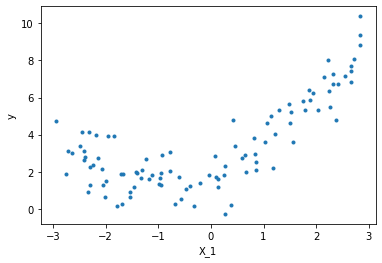

In [13]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5* X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, '.')
plt.xlabel('X_1')
plt.ylabel('y')
plt.show()

A straight line could never fit this data very well. We will use Scikit-Learn's `PolynomialFeatures` class to transform our training data. So instead of training with just `X`, we will also train with the square of it:

In [14]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[:5])
print(X_poly[:5])

[[-1.77605128]
 [ 0.37754643]
 [-2.7486183 ]
 [-2.41717896]
 [-0.68180841]]
[[-1.77605128  3.15435816]
 [ 0.37754643  0.14254131]
 [-2.7486183   7.55490254]
 [-2.41717896  5.84275415]
 [-0.68180841  0.46486271]]


You can see that the `X` array has just the linear `X` features, but `X_poly` has all `X` and their squares. Then we can use a `LinearRegression` model to the extended training data like we did before:

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.87475685]), array([[0.92813497, 0.5315527 ]]))

The model predicts $\hat{y}=0.52x^2+0.97x+1.89$ while the real function was $\hat{y}=0.5x^2+x+2+\text{Gaussian Noise}$.

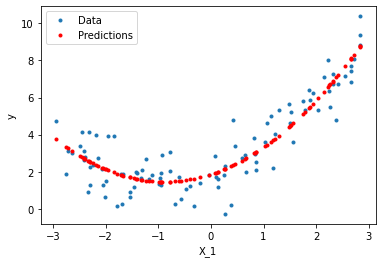

In [16]:
plt.plot(X, y, '.')
plt.plot(X, lin_reg.predict(X_poly), 'r.')
plt.legend(['Data', 'Predictions'])
plt.xlabel('X_1')
plt.ylabel('y')
plt.show()

## Learning Curves

A high-degree polynomial regression model is very likely to overfit the above data because it will attempt to get as close to the training instances as possible, resulting in a wiggly curve. On the other hand, a plain linear regression will underfit the data. How can we tell from a model's fitting error if it is overfitting or underfitting the data?

Before, we used cross-validation to get an estimate of a model's generalization performance. A model that performed well on the training data but then generalized poorly on cross-validation indicated overfitting. Performing poorly on both indicated underfitting.

We can also look at *learning curves*--plots of the model's performance on the training set and validation set as a function of the training set size (or the training iteration). To generate the plots, we train the model several times on different sized subsets of the training set.

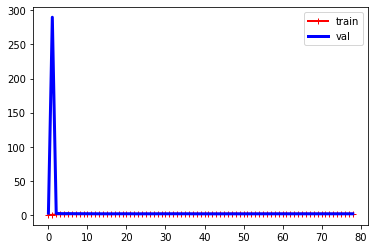

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label='val')
    plt.legend()
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

So, we know that this model underfits the data. When there are only one or two instances in the training set, the model can fit them perfectly, which is why the training error curve starts at zero. When new instances are added, it becomes impossible for the model to fit the training data perfectly, because of the data's noise and because it isn't linear at all. The error on the training data goes up until it reaches a plateau.

Now the model's performance on the validation data shows that when the model is trained on very few instances, it is incapable of generalizing properly, resulting in a large error. Then it starts to learn and the error goes down. But it can only do so well up to a certain point and so the error plateaus close to the other curve.

Tip: If a model is underfitting the training data, adding more training data will not help. A more complex model or more features is needed.

Now let's look at the learning curve for a 10th-degree polynomial model on the same data.

(0.0, 3.0)

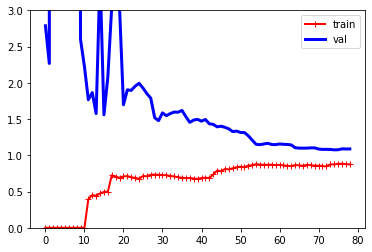

In [18]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)
plt.ylim(0, 3)

There are two important differences with these learning curves as compared to the previous ones for the linear model:

1. The error on the training data is much lower than with the Linear Regression model.
2. There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. If we used a much larger training set, however, the two curves would continue to get closer.

Tip: One way to improve an overfitting model s to feed it more training data until the validation error reaches the training error.

## The Bias/Variance Trade-Off

An important theoretical result of statistics and Machine Learning is the fact that a model's generalization error can be expressed as the sum of three errors:

*Bias*: This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.

*Variance*: This part is due to the model's excessive sensitivity to small variation in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance and thus overfit the training data.

*Irreducible Error*: This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).

Increasing a model's complexity will typically increase its variance and reduce its bias. Conservely, reducing a model's complexity increases its bias and reduces its variance. This is why it is called a trade-off.

## Regularized Linear Models

A good way to reduce overfitting is to regularize the model: the fewer degrees of freedom it has, the harder it wlil be to overfit the data. A simple way to regularize a polynomial model is to reduce the number of polynomial degrees.

For a linear model, regularization is typically achieved by constraining the weights of the model.

### Ridge Regression

*Ridge regression* (also called *Tikhonov regularization*) is a regularized version of Linear Regression: a *regularization term* equal to $\alpha\sum^n_{i=1}\theta_{i}^2$ is added to the cost function. This forces the learning algorithm to not only fit the data, but also keep the model weights as small as possible.

The regularization term is added only to the cost function during training. Once the model is trained, we use the unregularized performance measure to evaluate the model.

>Using different cost functions during training and testing is very common. For example, classifiers are often trained using a cost function such as the log los, but evaluated using precision/recall.

The hyperparameter $\alpha$. ontrols how much we want to regularize the model. If $\alpha=0$, then Ridge Regression is just linear regression. If $\alpha$ is very large, then all weights end up very close to zero and the result is a flat line going through the data's mean. The Ridge Regression cost function is:

$$
J(\mathbf{\theta})=\text{MSE}(\mathbf{\theta})+\alpha\frac{1}{2}\sum^{n}_{i=1}\theta_{i}^2
$$

Note that the bias term $\theta_{0}$ is not regularized (the sum starts at $i=1$, not 0). If we define $\mathbf{\text{w}}$ as the vector of feature weights ($\theta_1$ to $\theta_n$), then the regularization term is equal to $\frac{1}{2}(||\mathbf{\text{w}}||_{2})^2$, where $||\mathbf{\text{w}}||_{2}$ represents the $l_2$ norm of the weight vector. For gradient descent, just add $\alpha\mathbf{\text{w}}$ to the MSE gradient vector.

>It is important to scale the data (e.g., using a `StandardScaler`) before performing Ridge Regression, as it is sensitive to the scale of the input features. 

As with linear regression, we can perform ridge regression either by computing a closed-form equation or with gradient descent. Closed form equation, where $\mathbf{\text{A}}$ is the $(n+1)\times(n+1)$ identity matrix, except with a 0 in the top-left cell, corresponding to the bias term:

$$
\hat{\mathbf{\theta}}=(\mathbf{\text{X}}^{\text{T}}\mathbf{\text{X}}+\alpha\mathbf{\text{A}}^{-1})\mathbf{\text{X}}^{T}\mathbf{\text{y}}
$$


If we want to perform ridge regression with Scikit-Learn using a closed form solution, we can do this:

In [19]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.90741746]])

Or using stochastic gradient descent:

In [20]:
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.88758664])

The `penalty` hyperparameter sets the type of regularization term to use. Specifying `l2` indicates that we want SGD to add a regularization term to the cost function equal to half the square of the $l_2$ norm of the weight vector: this is simply Ridge Regression. The default `penalty` hyperparameter is actually `l2`, and so to perform plain stochastic gradient descent we actually have to set it to `None`.

### Chapter 4 Exercises

1. Which Linear Regression training algorithm can you use if you have a training set with millions of features?
> If you have millions of features, it will be important to use a gradient descent linear regression algorithm rather than a closed-form algorithm like the Normal Equation or Singular Value Decomposition. For example, the Normal Equation requires inverting a matrix which is typically a O(n^2.4) to O(n^3) operation. Using an algorithm like Stochastic, Batch, or Mini-batch gradient descent will result in a much quicker convergence with a similar answer.

2. Suppose the features in your training set have very different scales. Which algorithms might suffer from this, and how? What can you do about it?
> Gradient descent and its regularized forms will suffer from features having very different scales because the stretching that can result from it will cause convergence to happen much less quickly. To combat this, we can standardize the data with `StandardScaler`, i.e. subtract the means and divide by the standard deviations.

3. Can gradient descent get stuck in a local minimum when training a Logistic Regression model?
> No. The cost function for logistic regression with gradient descent is called the log loss function, and it is convex. Gradient descent is guaranteed to find the global minimum if the learning rate is set to an appropriate number and we wait long enough.

4. Do all Gradient Descent algorithms lead to the same model, provided you let them run long enough?
> Not quite. The gradient descent algorithms which have convex cost functions (e.g. linear regression and logistic regression) can all lead to the same model provided you let them run long enough and you set a good learning schedule. But, if you don't, mini-batch and stochastic gradient descent will just walk around the minimum forever while batch gradient descent will reach the minimum, but just take longer than the other two algorithms.

5. Suppose you use Batch Gradient Descent and you plot the validation error at every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?
> The important details here are that we are plotting the validation error at every epoch, i.e. on every iteration through the entire dataset (since this is batch gradient descent we're using the entire dataset each round in the epoch), and the validation error *consistently* goes up. If the validation error had reached a minimum and then started going up, we would conclude that the model was overfitting the data. However, since it has only *ever* gone *up*, that means that the learning rate is way too high and the algorithm is diverging away from the minimum of the cost function. A way to fix this would be to reduce the learning rate.

6. Is it a good idea to stop Mini-batch gradient descent immediately when the validation error goes up?
> This is an example of a technique known as *Early Stopping*. Because mini-batch gradient descent tends to have an erratic walk toward the minimum, it may not be a good idea to stop the algorithm immediately when the validation error goes up, because it could be a false minimum. A better idea is to stop only after a certain number of iterations have passed by after reaching that minimum validation error.

7. Which Gradient Descent algorithm will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?
> Stochastic gradient descent will reach the vicinity of the minimum the fastest but may not converge as fast as batch gradient descent because of its stochasticity. Similarly, mini-batch gradient descent tends to be erratic as well. Batch gradient descent will converge to the minimum without extra work, unless the learning rate is way too high. To make stochastic and mini-batch gradient descent converge, we can adjust the learning rate to a smaller amount as we get closer and closer to the minimum. This will make the algorithms get closer to the solution that batch gradient descent would get.

8. Suppose you are using Polynomial Regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?
> A large gap between the training and validation error can mean that the model is severely overfitting: the model memorizes the training set and hence reports a smaller erorr, but does not generalize well at all and when the validation set comes by, it produces terrible predictions, resulting in a high validation error. One way to reduce the overfitting is to use a much larger training set. Another simpler method would be to reduce the degree of the polynomial fit, e.g. go from 10 degrees to 7.

9. Suppose you are using ridge regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter $\alpha$ of reduce it?
> Since both the training and validation errors are high, the model is likely underfitting the data and hence it suffers from high bias, i.e. the model is too simple. The regularizaiton parameter can have an effect of controlling the model's bias; a large $\alpha$ will force weights to be closer to zero effectively increasing the bias. Therefore we should try reducing $\alpha$ to increase the variance of the model.